In [20]:
using Revise

using RealNeuralNetworks
using RealNeuralNetworks.Neurons

using JLD2
using JLD
using JuliaDB
using SparseArrays
using ProgressMeter
using PyPlot

using Distances
using Statistics

const DATASET_DATE = "1125"

"1125"

In [21]:
println("load dendritic nblast similarity matrix")
using JLD2

JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/dendriticNBLASTSimilarityMatrix.jld2" dendriticNBLASTSimilarityMatrix

load dendritic nblast similarity matrix


1-element Array{Symbol,1}:
 :dendriticNBLASTSimilarityMatrix

# load data
including neuronIdList, morphological similarity matrix and connectivity matrix

In [35]:
# db = JuliaDB.load("../01_data/$(DATASET_DATE)/postprocessed/db")
db = JuliaDB.loadtable("../01_data/$DATASET_DATE/postprocessed/features.csv")

neuronIdList = select(db, :neuronId)

2227-element Array{Int64,1}:
 76497
 78406
 77672
 79475
 79072
 77902
 78953
 78979
 77449
 76455
 77504
 79323
 78764
     ⋮
 77025
 77938
 78426
 79772
 76868
 80318
 78061
 80330
 80354
 76270
 78804
 78447

# Compute the similarity/distance matrix according to connectivity profile

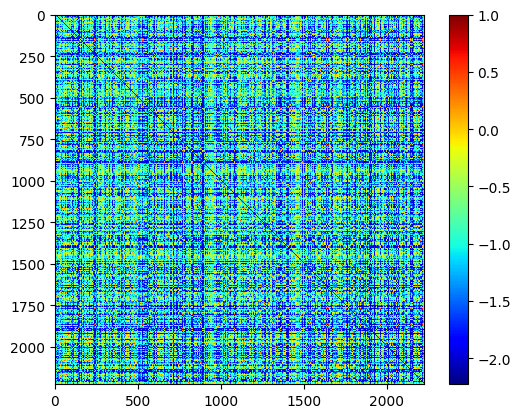

PyObject <matplotlib.colorbar.Colorbar object at 0x7f67d772cbe0>

In [36]:
using JLD2
JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/similarityMatrix.jld2" similarityMatrix

@assert size(similarityMatrix,1) == length(neuronIdList)


PyPlot.imshow(similarityMatrix, cmap="jet")
PyPlot.colorbar()

In [48]:
# load synaptic connectivity matrix
# using JLD

JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/synNumConnMatrix.jld2" synNumConnMatrix
JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/psdSizeConnMatrix.jld2" psdSizeConnMatrix

# synNumConnMatrix = Array{Float64}(synNumConnMatrix)
# psdSizeConnMatrix = Array{Float64}(psdSizeConnMatrix)

@assert length(neuronIdList) == size(synNumConnMatrix,1)

Progress:  96%|███████████████████████████████████████  |  ETA: 0:00:05

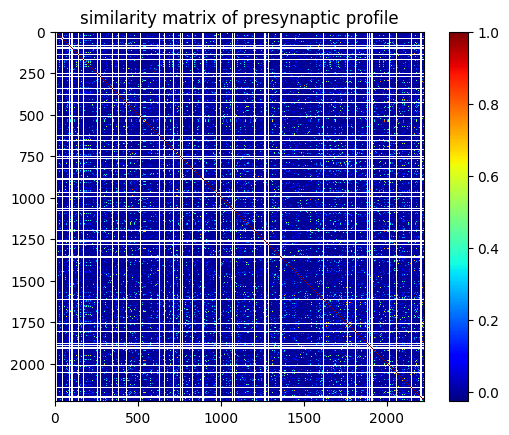

Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


PyObject Text(0.5, 1.0, 'similarity matrix of presynaptic profile')

In [49]:
synNumAxonDistMatrix = zeros(Float64, size(synNumConnMatrix))

@inbounds @showprogress 1 "compute connectivity profile distance matrix..." for i in 1:length(neuronIdList)
    profile1 = synNumConnMatrix[i,:]
    for j in i+1:length(neuronIdList)
        profile2 = synNumConnMatrix[j,:]
        local distance::Float64
#         if all(profile1.==0.) && all(profile2.==0.)
#             distance = 0. 
#         elseif all(profile1.==0.) || all(profile2.==0.)
#             distance = 1.
#         else
#             distance = Distances.cosine_dist(profile1, profile2)
#         end
#         distance = Distances.cosine_dist(profile1, profile2)
        # use pearson correlation coefficient
        distance = 1.0 .- cor(profile1, profile2)
        synNumAxonDistMatrix[i,j] = distance
        synNumAxonDistMatrix[j,i] = synNumAxonDistMatrix[i,j]
    end
end

synNumAxonSimilarityMatrix = 1.0 .- synNumAxonDistMatrix

using PyPlot
PyPlot.imshow(synNumAxonSimilarityMatrix, cmap="jet")
PyPlot.colorbar()
PyPlot.title("similarity matrix of presynaptic profile")

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:02

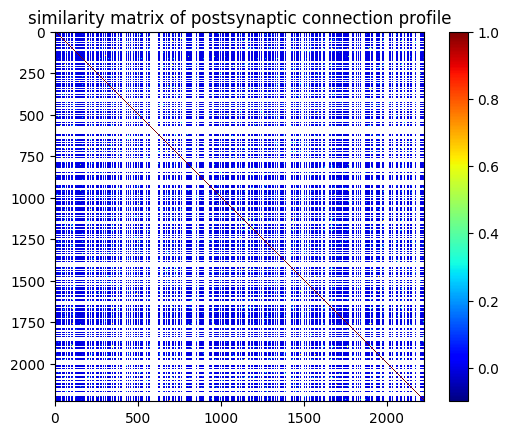

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


PyObject Text(0.5, 1.0, 'similarity matrix of postsynaptic connection profile')

In [50]:


synNumDendDistMatrix = zeros(Float64, size(synNumConnMatrix))

@inbounds @showprogress 1 "compute dendritic connectivity profile distance matrix..." for i in 1:length(neuronIdList)
    profile1 = synNumConnMatrix[:,i]
    for j in i+1:length(neuronIdList)
        profile2 = synNumConnMatrix[:, j]
#         local distance::Float64
#         if all(profile1.==0.) && all(profile2.==0.)
#             distance = 0. 
#         elseif all(profile1.==0.) || all(profile2.==0.)
#             distance = 1.
#         else
#             distance = Distances.cosine_dist(profile1, profile2)
#         end
#         distance = Distances.cosine_dist(profile1, profile2)
        distance = 1.0 .- cor(profile1, profile2)
        synNumDendDistMatrix[i,j] = distance
        synNumDendDistMatrix[j,i] = synNumDendDistMatrix[i,j]
    end
end

synNumDendSimilarityMatrix = 1.0 .- synNumDendDistMatrix

using PyPlot
PyPlot.imshow(synNumDendSimilarityMatrix, cmap="jet")
PyPlot.colorbar()
PyPlot.title("similarity matrix of postsynaptic connection profile")

# Combined similarity matrix

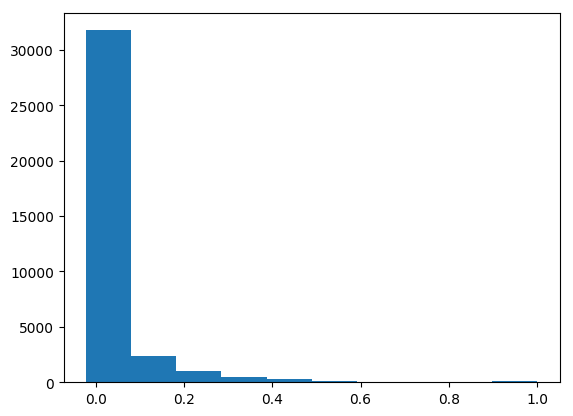

([31763.0, 2353.0, 991.0, 503.0, 261.0, 134.0, 50.0, 35.0, 6.0, 95.0], [-0.0217476, 0.0804271, 0.182602, 0.284777, 0.386951, 0.489126, 0.591301, 0.693476, 0.79565, 0.897825, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f67d7558240>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d758add8>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d7558518>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d7558860>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d7558ba8>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d7558ef0>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d757b278>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d757b5c0>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d757b908>, PyObject <matplotlib.patches.Rectangle object at 0x7f67d757bc50>])

In [51]:
PyPlot.plt[:hist]((synNumAxonSimilarityMatrix)[1:100:end], bins=10)

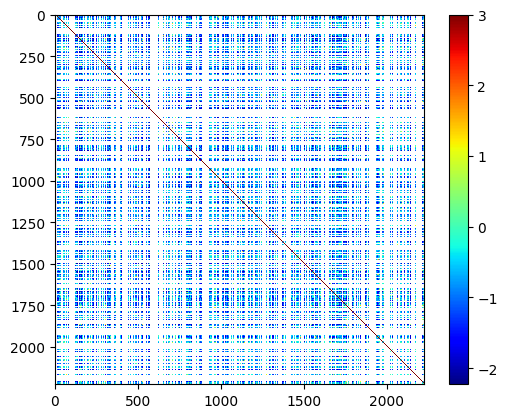

PyObject <matplotlib.colorbar.Colorbar object at 0x7f67cb6d1278>

In [52]:
combinedSimilarityMatrix = zeros(Float64, size(similarityMatrix))

combinedSimilarityMatrix = similarityMatrix .+ synNumAxonSimilarityMatrix .+ synNumDendSimilarityMatrix

PyPlot.imshow(combinedSimilarityMatrix, cmap="jet")
PyPlot.colorbar()

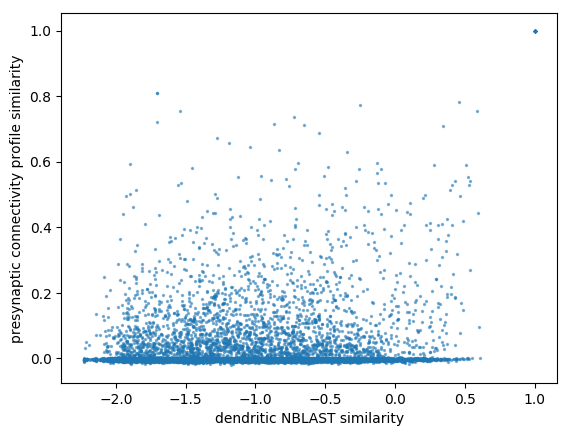

PyObject Text(24.000000000000007, 0.5, 'presynaptic connectivity profile similarity')

In [60]:
using PyPlot

println("load dendritic nblast similarity matrix")
using JLD2

JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/dendriticNBLASTSimilarityMatrix.jld2" dendriticNBLASTSimilarityMatrix

PyPlot.scatter(vec(dendriticNBLASTSimilarityMatrix)[1:50:end], vec(synNumAxonSimilarityMatrix)[1:50:end], s=2, alpha=0.5)
# PyPlot.xlim(0,)
PyPlot.xlabel("dendritic NBLAST similarity")
PyPlot.ylabel("presynaptic connectivity profile similarity")


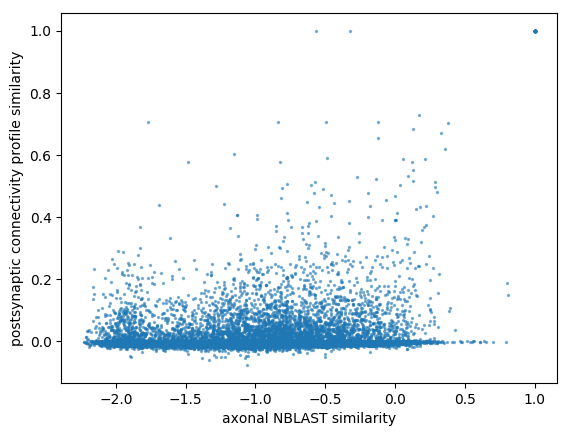

load axonal nblast similarity matrix


PyObject Text(24.00000000000002, 0.5, 'postsynaptic connectivity profile similarity')

In [66]:
using PyPlot

println("load axonal nblast similarity matrix")
using JLD2

JLD2.@load "../01_data/$(DATASET_DATE)/postprocessed/axonNBLASTSimilarityMatrix.jld2" axonNBLASTSimilarityMatrix

PyPlot.scatter(vec(axonNBLASTSimilarityMatrix)[1:50:end], vec(synNumDendSimilarityMatrix)[1:50:end], s=2, alpha=0.5)
# PyPlot.xlim(0,)
PyPlot.xlabel("axonal NBLAST similarity")
PyPlot.ylabel("postsynaptic connectivity profile similarity")

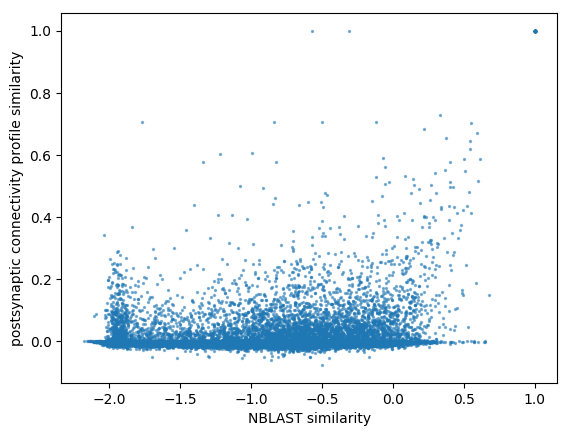

PyObject Text(24.00000000000002, 0.5, 'postsynaptic connectivity profile similarity')

In [62]:
using PyPlot

PyPlot.scatter(vec(similarityMatrix)[1:50:end], vec(synNumDendSimilarityMatrix)[1:50:end], s=2, alpha=0.5)
# PyPlot.xlim(0,)
PyPlot.xlabel("NBLAST similarity")
PyPlot.ylabel("postsynaptic connectivity profile similarity")

In [63]:
using Statistics
@show Statistics.cor(vec(similarityMatrix), vec(1.0 .- synNumAxonDistMatrix))

Statistics.cor(vec(similarityMatrix), vec(1.0 .- synNumAxonDistMatrix)) = NaN


NaN

In [64]:
using Clustering

apResult = Clustering.affinityprop(similarityMatrix)



AffinityPropResult([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 23, true)